# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [116]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [117]:
# Import essential libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import PIL
import PIL.Image
import pathlib
import requests
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

Load the dataset.

In [118]:
# Load and unzip the dataset
response = requests.get('https://drive.usercontent.google.com/download?id=1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM&export=download&authuser=0&confirm=t&uuid=8a7ccb90-ea5a-47f2-b5bb-eb29f75f9926&at=AN8xHoonSBPl5THR5M6tuy2m-h9L%3A1749906860972')
response.raise_for_status()
with open('data.zip', 'wb') as f:
    f.write(response.content)

!unzip data.zip


Archive:  data.zip
replace data/Food_Waste/file_931.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [119]:
#set the path for unzipped data

data_dir = pathlib.Path('data')

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [120]:
# Create a function to load the raw images

def load_and_preprocess_images(directory, img_height, img_width, resize=False, crop=False):
    images = []
    labels = []
    labels_names = os.listdir(directory)

    for label_name in labels_names:
        label_path = os.path.join(directory, label_name)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(label_path, filename)
                    img = PIL.Image.open(img_path)

                    # Optionally resize the image
                    if resize:
                        img = img.resize((img_width, img_height))

                    # Optionally crop the image
                    if crop:
                        img = img.crop((0, 0, img_width, img_height))

                    images.append(img)
                    labels.append(label_name)

    return images, labels


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [121]:
# Get the images and their labels
images, labels = load_and_preprocess_images(data_dir, 256, 256, resize=False, crop=False)



In [122]:
#Check the Labels
set(labels)

{'Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic'}

In [123]:
#Print total images and labels
print('Total Images: ', len(images))
print('Total Labels: ', len(labels))

Total Images:  7625
Total Labels:  7625


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

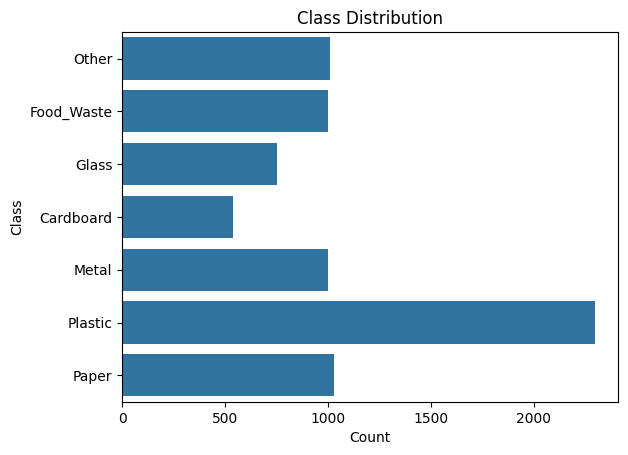

In [124]:
# Visualise Data Distribution
sns.countplot(labels)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

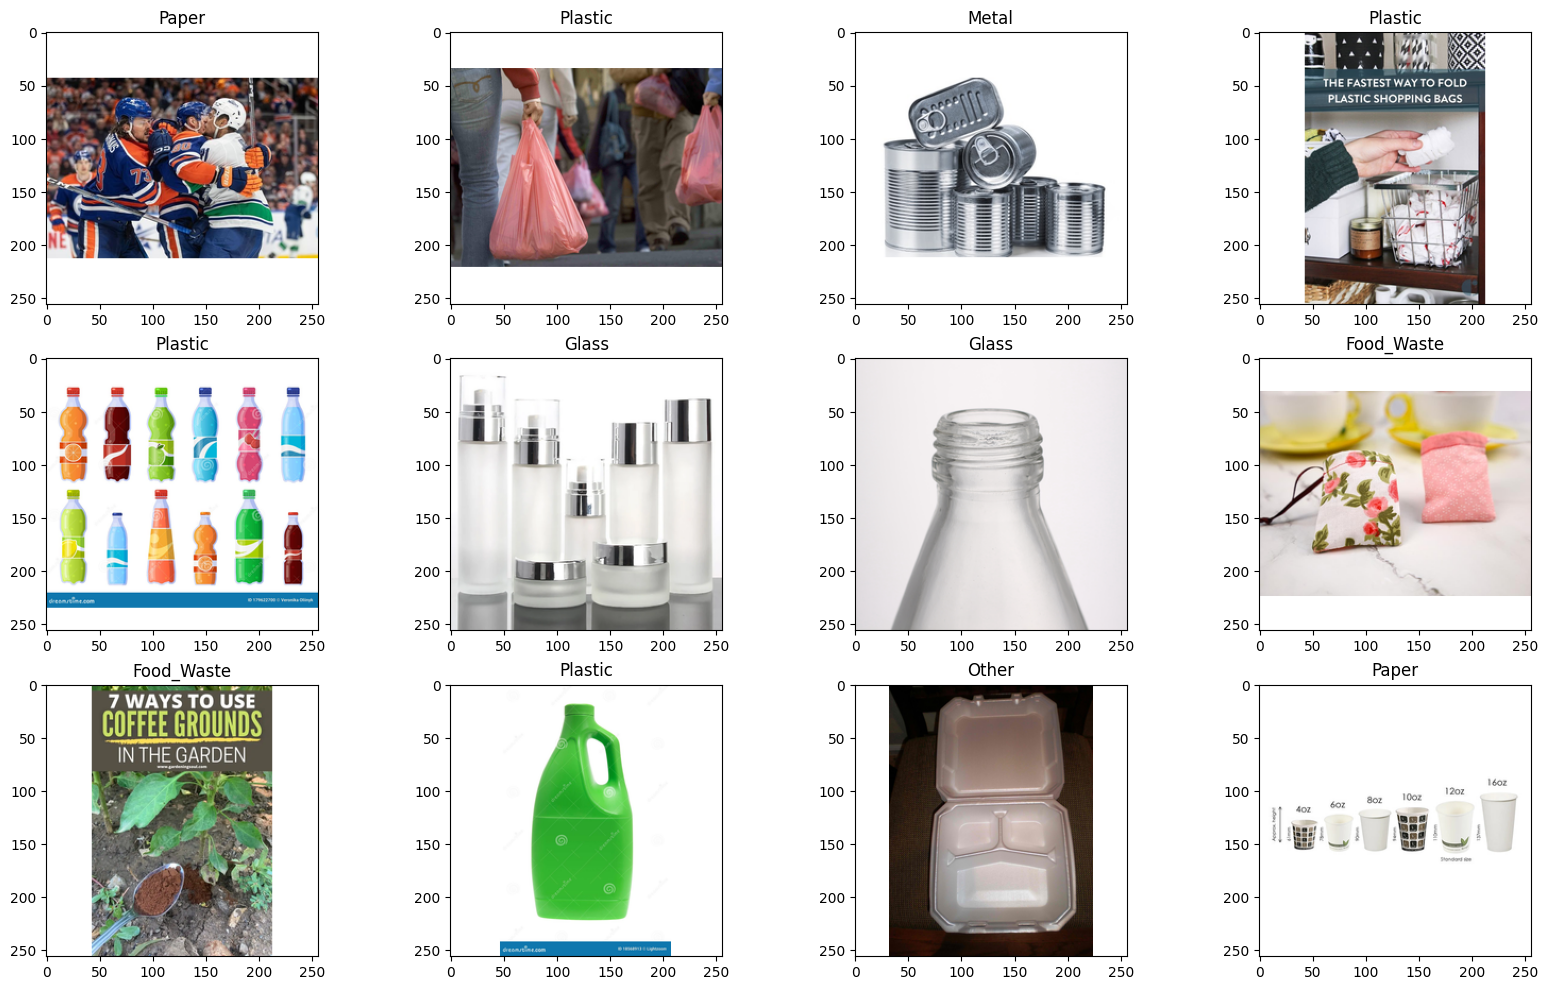

In [125]:
# Visualise Sample Images (across different labels)
index_list = np.random.randint(low = 0, high = len(images), size = 12)
plt.figure(figsize=(20,12))
for i,j in zip(index_list, range(0,12)):
  plt.subplot(3,4,j+1)
  plt.imshow(images[i])
  plt.title(labels[i])

plt.show()



#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [126]:
#Function to find the Minimum and Maximum Image Sizes
def image_size(directory):
    labels_names = os.listdir(directory)
    min_width = 512
    min_height = 512
    max_width = 180
    max_height = 180
    for label_name in labels_names:
        label_path = os.path.join(directory, label_name)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(label_path, filename)
                    img_width, img_height = PIL.Image.open(img_path).size

                    if img_width < min_width:
                        min_width = img_width
                    elif img_width > max_width:
                        max_width = img_width

                    if img_height < min_height:
                        min_height = img_height
                    elif img_height > max_height:
                        max_height = img_height

    return (min_width,min_height), (max_width, max_height)

In [127]:
# Find the smallest and largest image dimensions from the data set

min_dimen, max_dimen = image_size(data_dir)
print(f'Max Dimensions: {max_dimen}')
print(f'Min Dimensions: {min_dimen}')

Max Dimensions: (256, 256)
Min Dimensions: (256, 256)


In [128]:
# Resize the image dimensions

images, labels = load_and_preprocess_images(data_dir, 256, 256, resize=True, crop=False)


In [129]:
#Convert images and labels from PIX Image format to numpy arrays
images = np.asarray(images)
labels = np.asarray(labels)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
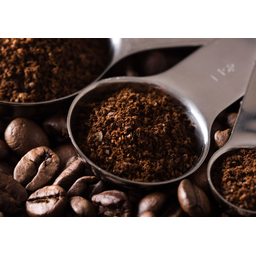

In [130]:
#Check the image and associated label after converting to numpy array
images[1550]

In [131]:
labels[1550]

np.str_('Food_Waste')

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [132]:
# Encode the labels suitably
num_classes = len(set(labels))
label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)

In [133]:
#Check the encoding
set(labels)

{np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6)}

In [134]:
#Reshape the labels array
labels = labels.reshape(-1,1)

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [135]:
# Assign specified parts of the dataset to train and validation sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=24)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=24)

In [136]:
y_train

array([[4],
       [2],
       [3],
       ...,
       [0],
       [6],
       [6]])

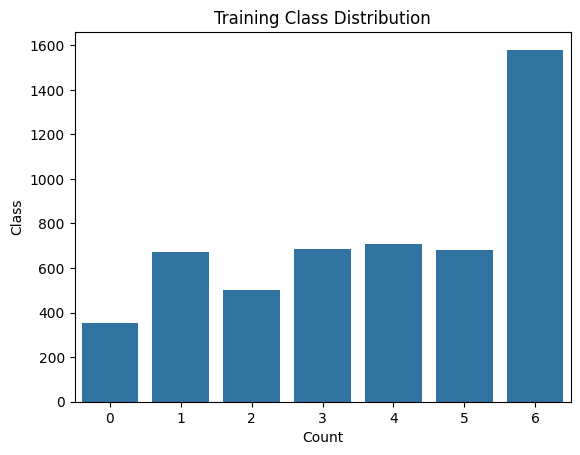

In [137]:
sns.countplot(x=y_train[:,0])
plt.title('Training Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

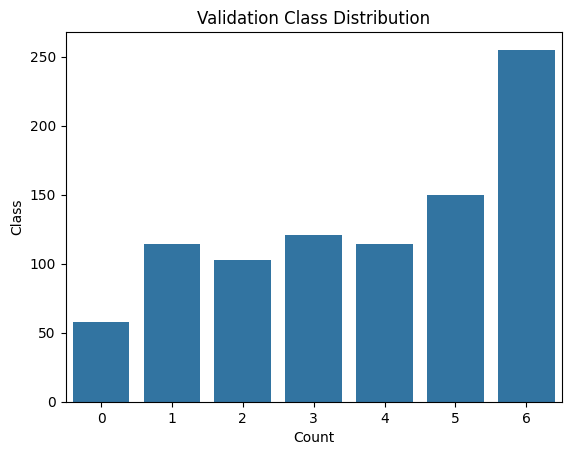

In [138]:
sns.countplot(x=y_val[:,0])
plt.title('Validation Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

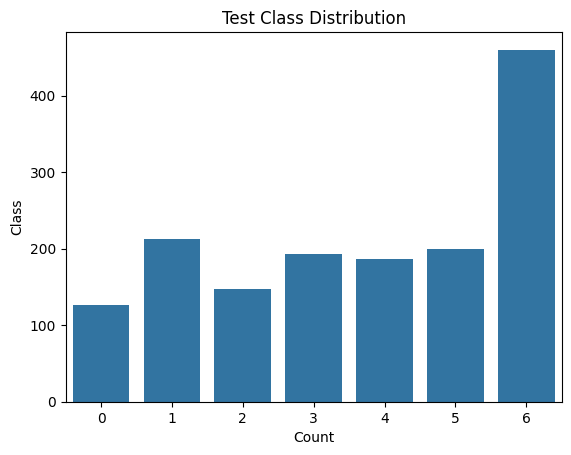

In [139]:
sns.countplot(x=y_test[:,0])
plt.title('Test Class Distribution')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

In [140]:
#Convert target to binary matrix representation
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [141]:
#Convert to float dtype
X_train = X_train.astype('float16')
X_test = X_test.astype('float16')
X_val = X_val.astype('float16')

In [142]:
#Normalize the input image
X_train /=255
X_test /=255
X_val /=255

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [151]:
# Build and compile the model
batch_size = 32

model = Sequential()
# Convolutional Layer 1

model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#Convolutional Layer 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Convolutional Layer 3
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.3))

model.add(Flatten())

#Fully Connected Layer 1
model.add(Dense(128,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.5))

#Fully Connected Layer 2
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(layers.BatchNormalization())
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [152]:
print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256, 256, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,513,543 (32.48 MB)

 Trainable params: 8,512,647 (32.47 MB)

 Non-trainable params: 896 (3.50 KB)

None


In [153]:
#Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [146]:
#Check the size of train, validation and test datasets
print(f"Training DataSet Shape: {X_train.shape}")
print(f"Validation DataSet Shape: {X_val.shape}")
print(f"Test DataSet Shape: {X_test.shape}")

Training DataSet Shape: (5185, 256, 256, 3)
Validation DataSet Shape: (915, 256, 256, 3)
Test DataSet Shape: (1525, 256, 256, 3)


In [147]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # Metric to monitor
    factor=0.5,         # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,         # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,     # Lower bound on the learning rate
    verbose=1           # Print messages when learning rate is reduced
)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [154]:
# Training
epochs = 30
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val), shuffle=True, callbacks=[reduce_lr])


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 195ms/step - accuracy: 0.2065 - loss: 7.0472 - val_accuracy: 0.2055 - val_loss: 4.4555 - learning_rate: 0.0010
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.3069 - loss: 4.1416 - val_accuracy: 0.2907 - val_loss: 3.4219 - learning_rate: 0.0010
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.3421 - loss: 3.2246 - val_accuracy: 0.2907 - val_loss: 3.1455 - learning_rate: 0.0010
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.3486 - loss: 3.0150 - val_accuracy: 0.1956 - val_loss: 3.6114 - learning_rate: 0.0010
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.3719 - loss: 2.9775 - val_accuracy: 0.2131 - val_loss: 4.0308 - learning_rate: 0.0010
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.3810 - loss: 2.8923 - val_accuracy: 0.3432 - val_loss: 2.9879 - learning_rate: 0.0010
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.4

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [157]:
# Evaluate on the test set; display suitable metrics

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9786282777786255
Test accuracy: 0.6236065626144409


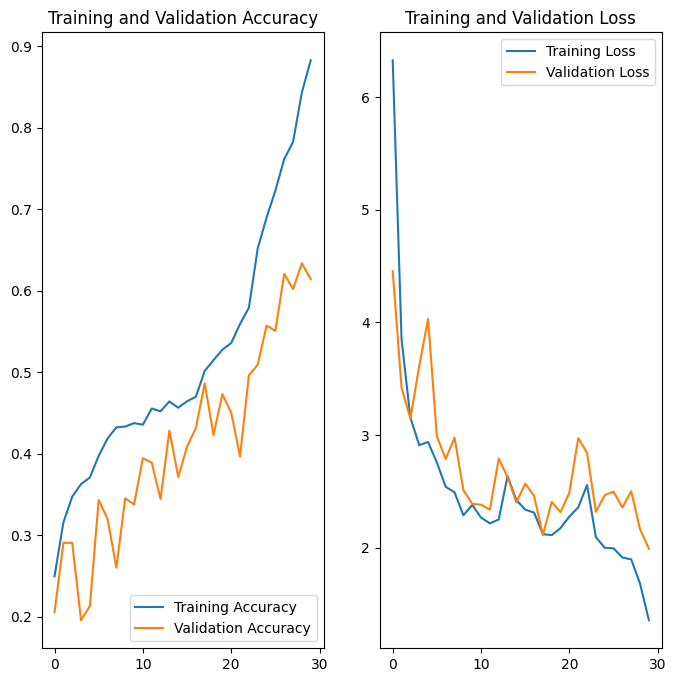

In [156]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

**Observations about Data:**

Dataset size is 7523 which is not enough for CNN models.

Class imbalance exists i.e higher number of images with plastic as label exist.


**Model Training Results:**

Models have consistently either underfit or overfit.
Where accuracy for Train, validation and test dataset is similar, the percentage of accuracy is very low and the model was underfitting.

Where accuracy for training is high but validation/test accuracies are no way near as high as training which is overfitting as the model is picking up noise in the data along with patterns.

Introducing Reduce Learning Rate on Plateau has not improved the validation accuracy beyond a certain point.

**Model run results:**

# Run 1

C1 - 128 Features, KS=(3,3), No BN, NO Max Pooling, No Dropouts

C2 - 64 Features, KS=(3,3), BN, Max Pooling, Dropouts

C3 - 64 Features, KS=(3,3), BN, Max Pooling, Dropouts

FC1 - 128, L2regularizer, Dropout (0.5)

FC2 - 128, L2regularizer, Dropout (0.5)

Result: accuracy: 0.3240 - loss: 2.9211 - val_accuracy: 0.3246 - val_loss: 2.9205

Test loss: 2.9306800365448
Test accuracy: 0.29967212677001953

RESULT: UNDERFITS


# Run 2

C1 - 128 Features, KS=(3,3), No BN, NO Max Pooling, No Dropouts

C2 - 64 Features, KS=(3,3), BN, Max Pooling, Dropouts

C3 - 64 Features, KS=(3,3), BN, Max Pooling, Dropouts

FC1 - 128, L2regularizer, Dropout (0.5)

Single FC Layer

Memory use: 32.44 MB

Result: accuracy: 0.5292 - loss: 2.1127 - val_accuracy: 0.4574 - val_loss: 2.7985

Test loss: 2.892993927001953
Test accuracy: 0.4399999976158142

RESULT: UNDERFITS


# Run 3

C1 - 128 Features, KS=(3,3), No BN, NO Max Pooling, No Dropouts

C2 - 64 Features, KS=(3,3), BN, Max Pooling, Dropouts

C3 - 64 Features, KS=(3,3), BN, Max Pooling, Dropouts

FC1 - 128, L2regularizer, Dropout (0.5)

FC2 - 64, L2regularizer, No Dropout (0.5)

Memory: 32.47 MB

Result: accuracy: accuracy: 0.6289 - loss: 2.1680 - val_accuracy: 0.5295 - val_loss: 2.4582

Test loss: 2.447486162185669
Test accuracy: 0.5403278470039368

RESULT: Higher Loss

#Run 7

C1 - 128 Features, KS=(3,3), BN, Max Pooling, Dropouts

C2 - 64 Features, KS=(3,3), BN, Max Pooling, Dropouts

C3 - 64 Features, KS=(3,3), BN, Max Pooling, No Dropouts

FC1 - 128, L2regularizer, Dropout (0.5)

FC2 - 64, L2regularizer, Dropout (0.5)

Memory: 32.57 MB

Result: accuracy: 0.9420 - loss: 0.9834 - val_accuracy: 0.6273 - val_loss: 1.9064 - learning_rate: 1.2500e-04

Test loss: 1.8626000881195068
Test accuracy: 0.643934428691864

#Run 15

C1 - 128 Features, KS=(3,3), BN, Max Pooling, No Dropouts

C2 - 64 Features, KS=(3,3), BN, Max Pooling, Dropouts

C3 - 64 Features, KS=(3,3), BN, Max Pooling, No Dropouts

FC1 - 128, L2regularizer, Dropout (0.5)

FC2 - 64, L2regularizer, Dropout (0.5)

Memory: 32.57 MB

Result: accuracy: 0.8920 - loss: 1.3780 - val_accuracy: 0.6142 - val_loss: 1.9907 - learning_rate: 1.2500e-04

Test loss: 1.9786282777786255
Test accuracy: 0.6236065626144409


#CONCLUSIONS:

We could potentially increase the depth of CNN to learn more complex patterns and reduce noise.

Augmentation could help allowing the model to learn more features.

Increasing the size of the dataset could allow the model to better generalise and improve the accuracy on test/validation data.



